In [47]:
# preprocessing images

import os, random, cv2
import numpy as np
import imutils.paths as paths
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

In [11]:
num_images = 1200

In [9]:
dir_paths = os.listdir('./Train')
dir_paths.sort()
print(dir_paths)

root_path = './Train'

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [15]:
from tqdm import tqdm


for idx, dir_path in tqdm(enumerate(dir_paths), total=len(dir_paths)):
    all_images = os.listdir(f'{root_path}/{dir_path}')
    os.makedirs(f"./preprocessed_image/{dir_path}", exist_ok=True)
    for i in range(num_images):
        rand_id = random.randint(0, 2999)
        image = cv2.imread(f'{root_path}/{dir_path}/{all_images[rand_id]}')
        image = cv2.resize(image, (244, 244))
        cv2.imwrite(f"./preprocessed_image/{dir_path}/{dir_path}{i}.jpg", image)

100%|██████████| 29/29 [01:48<00:00,  3.74s/it]


In [30]:
# building data.csv containing image_paths and its labels

image_paths = list(paths.list_images('./Train'))
# print(image_paths)
data = pd.DataFrame()

labels = []

for i, image_path in tqdm(enumerate(image_paths), total =len(image_paths)):
    label = image_path.split(os.path.sep)[-2]
    data.loc[i, 'image_path'] = image_path
    
    labels.append(label)

labels = np.array(labels)

from sklearn.preprocessing import LabelBinarizer


# Mapping the first one hot encoded label to its category
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

for i in range(len(labels)):
    index = np.argmax(labels[i])
    data.loc[i, 'target'] = int(index)

data = data.sample(frac=1).reset_index(drop=True)
# data.to_csv('../input/data.csv', index=False)



    

100%|██████████| 87000/87000 [03:38<00:00, 398.47it/s] 


In [27]:
data.to_csv('./data.csv', index=False)

In [63]:
# Transforms
from torchvision import transforms


train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
    ])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
    ])

In [94]:
class ASL_dataset(Dataset):
    
    def __init__(self, csv_path, root_dir, transform=None):

        self.csv_file = pd.read_csv(csv_path)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
        image_name = os.path.join(self.csv_file.iloc[idx, 0])
        print(image_name)
        image = np.asarray(Image.open(image_name))
        
        labels = np.array(self.csv_file.iloc[idx, 1:]).astype(np.float32)
        print(labels)
        sample = {'image': image, 'labels': labels }
        if self.transform:
            sample = self.transform(sample)
        
        return sample
                                

            
        

./Train/E/E101.jpg
[4.]
0 (200, 200, 3) (1,)
./Train/space/space157.jpg
[28.]
1 (200, 200, 3) (1,)
./Train/Z/Z1332.jpg
[25.]
2 (200, 200, 3) (1,)
./Train/M/M1213.jpg
[12.]
3 (200, 200, 3) (1,)


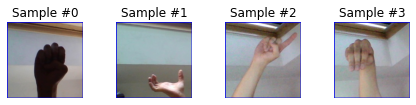

In [95]:
asl_dataset = ASL_dataset(csv_path='./data.csv',
                         root_dir=root_path)
import matplotlib.pyplot as plt
for i in range(len(asl_dataset)):
    sample = asl_dataset[i]
    print(i, sample['image'].shape, sample['labels'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break